<a href="https://colab.research.google.com/github/Nuelky/Finance/blob/main/MScFE_622_STOCHASTIC_MODELING_Group_Work_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Group 7907: Stochastic Modeling Group Work Project 1*** #

---
|  |  |
|:---|:---|
|**Team member 1** |  Vaibhav Janve |
|**Team member 2** | Emmanuel Kossy Okonkwo  |
|**Team member 3** | Thanh Tien Bui |

**Abbreviations**

- Eur: European  
- Amer: American
- As: Asian  
- BS: Black-Scholes  
- MC: Monte-Carlo
- OTC: Over the counter
- ATM: At-the-money  
- ITM: In-the-money
- OTM: Out-of-the-money

**STEP 1**.
a) calibrate a classic Heston (1993) model (without jumps) to the observed market prices for both call and put options. Use the Lewis (2001) approach with a regular MSE error function.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [ ]:
# Option Parameters
S0 = 232.90


In [ ]:
file_path = 'https://drive.google.com/uc?export=download&id=1bEtSz420806bYwNRG6njocjNSVQKFVp0'
data = pd.read_csv(file_path)

In [ ]:
data


,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C
5,60,227.5,16.78,C
6,60,230.0,17.65,C
7,60,232.5,16.86,C
8,60,235.0,16.05,C
9,60,237.5,15.10,C


In [ ]:
modified_data = data.pivot_table(
    index=["Days to maturity", "Strike"],
    columns="Type",
    values="Price",
    aggfunc="first"
).reset_index()

In [ ]:
modified_data.head()

Type,Days to maturity,Strike,C,P
0,15,227.5,10.52,4.32
1,15,230.0,10.05,5.20
2,15,232.5,7.75,6.45
3,15,235.0,6.01,7.56
4,15,237.5,4.75,8.78


In [ ]:
modified_data.columns = ["Days to maturity", "Strike", "Call", "Put"]


In [ ]:
# Option Selection
tol = 0.02 # Tolerance level to select ATM options (percent around ITM/OTM options)
options = modified_data[(modified_data['Days to maturity']==15) & ((np.abs(data["Strike"] - S0) / S0) < tol)]
options


<ipython-input-11-584329b33129>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  options = modified_data[(modified_data['Days to maturity']==15) & ((np.abs(data["Strike"] - S0) / S0) < tol)]


,Days to maturity,Strike,Call,Put
1,15,230.0,10.05,5.20
2,15,232.5,7.75,6.45
3,15,235.0,6.01,7.56
4,15,237.5,4.75,8.78


In [ ]:
for row, option in options.iterrows():
  T = option['Days to maturity'] / 250.0
  options.loc[row, "T"] = T
  options.loc[row, "r"] = 0.015

<ipython-input-12-acbb9c3c0a8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "T"] = T
<ipython-input-12-acbb9c3c0a8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.015


In [ ]:
options.head()

,Days to maturity,Strike,Call,Put,T,r
1,15,230.0,10.05,5.20,0.06,0.015
2,15,232.5,7.75,6.45,0.06,0.015
3,15,235.0,6.01,7.56,0.06,0.015
4,15,237.5,4.75,8.78,0.06,0.015


In [ ]:
i = 0
min_MSE = 500

In [ ]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
brute

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
          (1e-3, 10.0, 1.0),  # kappa_v
          (1e-3, 0.1, 0.01),  # theta_v
          (1e-2, 1.0, 0.05),  # sigma_v
          (-1.0, 0.0, 0.25),  # rho
          (1e-3, 0.1, 0.01), # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=2000
    )
    return opt

In [ ]:
H93_calibration_full()

   0 | [ 0.001  0.051  0.01  -1.     0.001] |  37.362 |  37.362
  25 | [ 0.001  0.051  0.01  -0.5    0.051] |   5.251 |   0.708
  50 | [ 0.001  0.061  0.01  -0.75   0.001] |  37.363 |   0.708
  75 | [ 0.001  0.061  0.01  -0.25   0.051] |   5.251 |   0.708
 100 | [ 0.001  0.071  0.01  -0.5    0.001] |  37.363 |   0.708
 125 | [ 0.001  0.081  0.01  -1.     0.051] |   5.251 |   0.708
 150 | [ 0.001  0.081  0.01  -0.25   0.001] |  37.363 |   0.708
 175 | [ 0.001  0.091  0.01  -0.75   0.051] |   5.251 |   0.708
 200 | [ 1.001e+00  1.100e-02  1.000e-02 -1.000e+00  1.000e-03] |  36.764 |   0.708
 225 | [ 1.001  0.011  0.01  -0.5    0.051] |   5.509 |   0.708
 250 | [ 1.001e+00  1.100e-02  6.000e-02 -7.500e-01  1.000e-03] |  36.765 |   0.708
 275 | [ 1.001  0.011  0.06  -0.25   0.051] |   5.514 |   0.708
 300 | [ 1.001e+00  1.100e-02  1.100e-01 -5.000e-01  1.000e-03] |  36.777 |   0.708
 325 | [ 1.001  0.021  0.01  -1.     0.051] |   5.444 |   0.708
 350 | [ 1.001e+00  2.100e-02  1.000e-02 -2.

array([ 1.19767001,  0.09007018,  0.46448758, -0.99981037,  0.10819943])

In [ ]:
kappa_v = 1.1977
theta_v = 0.0901
sigma_v = 0.4645
rho = -0.9998
v0 = 0.1082


In [ ]:
def H93_model_values():
    call_values = []
    put_values = []
    for row, option in options.iterrows():
        calibrated_call_price = H93_call_value(S0,
                                               option["Strike"],
                                               option["T"],
                                               option["r"],
                                               kappa_v,
                                               theta_v,
                                               sigma_v,
                                               rho,
                                               v0)
        calibrated_put_prices = calibrated_call_price - S0 + option["Strike"]*np.exp(-option["r"]*option["T"])

        call_values.append(calibrated_call_price)
        put_values.append(calibrated_put_prices)
    return np.array(call_values), np.array(put_values)

In [ ]:
options["H93_Call"], options["H93_Put"] = H93_model_values()


<ipython-input-20-b7e654ff5474>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["H93_Call"], options["H93_Put"] = H93_model_values()
<ipython-input-20-b7e654ff5474>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["H93_Call"], options["H93_Put"] = H93_model_values()


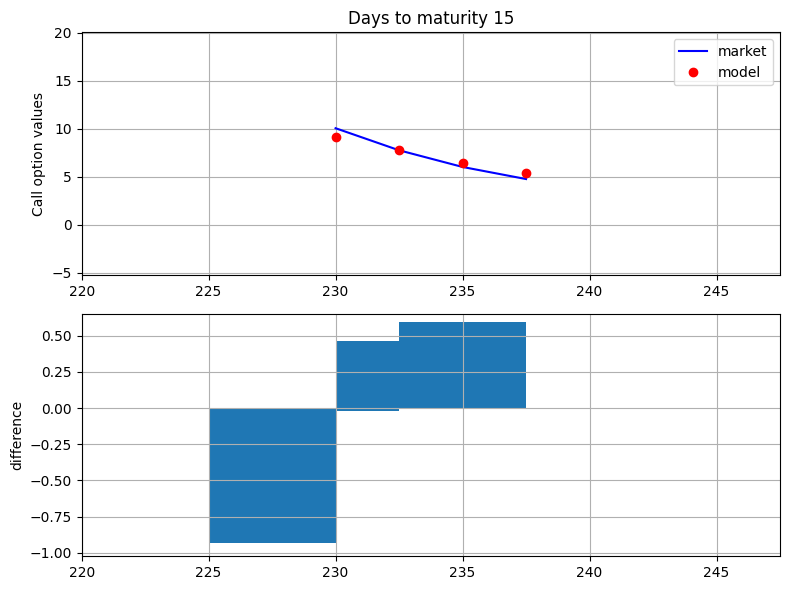

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
plt.ylabel("Call option values")
plt.plot(options.Strike, options.Call, "b", label="market")
plt.plot(options.Strike, options.H93_Call, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(options.Call) - 10,
        max(options.Call) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options.H93_Call.values - options.Call.values
plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

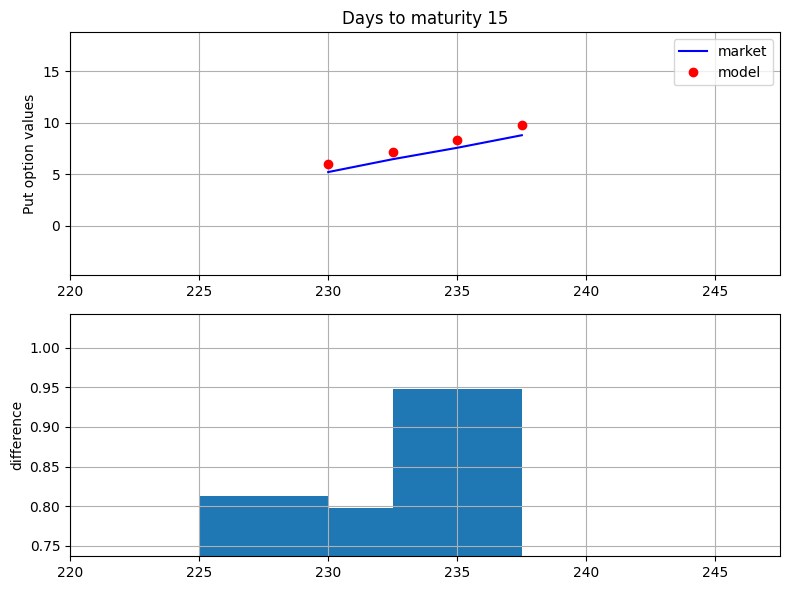

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
plt.ylabel("Put option values")
plt.plot(options.Strike, options.Put, "b", label="market")
plt.plot(options.Strike, options.H93_Put, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(options.Put) - 10,
        max(options.Put) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options.H93_Put.values - options.Put.values
plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

**STEP 1. B)**

using the Carr-Madan (1999) pricing approach to calibrate the Heston (1993)
model. Make sure that you repeat all the tasks in (a).


In [ ]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brute, minimize


In [ ]:
#option pricing using Carr Madan
def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Herton (1993) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue



In [ ]:
#calibration error function

i = 0
min_MSE = 500

def H93_error_function_FFT(p0):

    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_calibration_full_FFT():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function_FFT,
        (
          (1e-3, 10.0, 1.0),  # kappa_v
          (1e-3, 0.1, 0.01),  # theta_v
          (1e-2, 1.0, 0.05),  # sigma_v
          (-1.0, 0.0, 0.25),  # rho
          (1e-3, 0.1, 0.01), # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function_FFT, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=2000
    )
    return opt

In [ ]:
H93_calibration_full_FFT()

   0 | [ 0.001  0.051  0.01  -1.     0.001] |  37.362 |  37.362
  25 | [ 0.001  0.051  0.01  -0.5    0.051] |   5.251 |   0.708
  50 | [ 0.001  0.061  0.01  -0.75   0.001] |  37.363 |   0.708
  75 | [ 0.001  0.061  0.01  -0.25   0.051] |   5.251 |   0.708
 100 | [ 0.001  0.071  0.01  -0.5    0.001] |  37.363 |   0.708
 125 | [ 0.001  0.081  0.01  -1.     0.051] |   5.251 |   0.708
 150 | [ 0.001  0.081  0.01  -0.25   0.001] |  37.363 |   0.708
 175 | [ 0.001  0.091  0.01  -0.75   0.051] |   5.251 |   0.708
 200 | [ 1.001e+00  1.100e-02  1.000e-02 -1.000e+00  1.000e-03] |  36.764 |   0.708
 225 | [ 1.001  0.011  0.01  -0.5    0.051] |   5.509 |   0.708
 250 | [ 1.001e+00  1.100e-02  6.000e-02 -7.500e-01  1.000e-03] |  36.765 |   0.708
 275 | [ 1.001  0.011  0.06  -0.25   0.051] |   5.514 |   0.708
 300 | [ 1.001e+00  1.100e-02  1.100e-01 -5.000e-01  1.000e-03] |  36.777 |   0.708
 325 | [ 1.001  0.021  0.01  -1.     0.051] |   5.444 |   0.708
 350 | [ 1.001e+00  2.100e-02  1.000e-02 -2.

array([ 1.19767001,  0.09007018,  0.46448758, -0.99981037,  0.10819943])

In [ ]:
#Car-Madan
kappa_v_cm = 1.19767001
theta_v_cm = 0.09007018
sigma_v_cm = 0.46448758
rho_cm = -0.99981037
v0_cm = 0.10819943

In [ ]:
def H93_model_values_cm():
    call_values = []
    put_values = []
    for row, option in options.iterrows():
        calibrated_call_price = H93_call_FFT(S0,
                                               option["Strike"],
                                               option["T"],
                                               option["r"],
                                               kappa_v_cm,
                                               theta_v_cm,
                                               sigma_v_cm,
                                               rho_cm,
                                               v0_cm)
        calibrated_put_prices = calibrated_call_price - S0 + option["Strike"]*np.exp(-option["r"]*option["T"])

        call_values.append(calibrated_call_price)
        put_values.append(calibrated_put_prices)
    return np.array(call_values), np.array(put_values)

In [ ]:
options["H93_Call_CM"], options["H93_Put_CM"] = H93_model_values_cm()


<ipython-input-30-7cdaddbed057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["H93_Call_CM"], options["H93_Put_CM"] = H93_model_values_cm()
<ipython-input-30-7cdaddbed057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["H93_Call_CM"], options["H93_Put_CM"] = H93_model_values_cm()


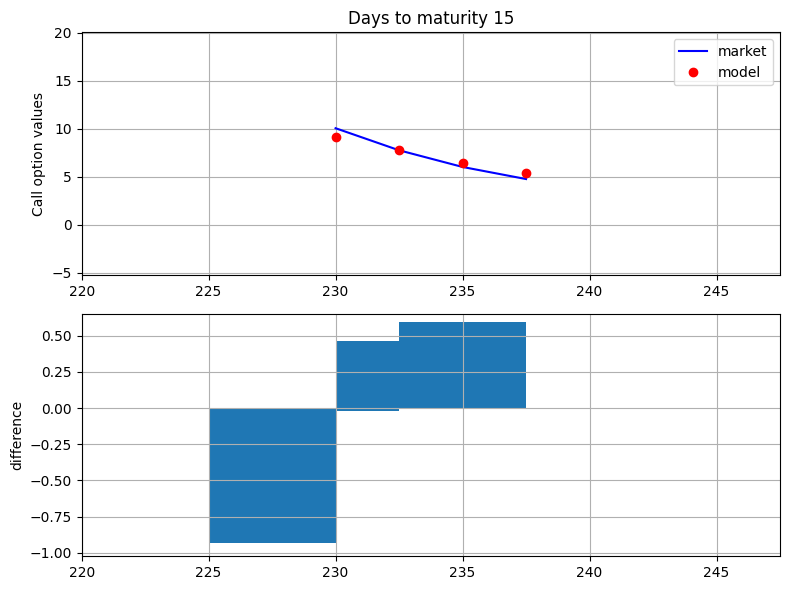

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
plt.ylabel("Call option values")
plt.plot(options.Strike, options.Call, "b", label="market")
plt.plot(options.Strike, options.H93_Call_CM, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(options.Call) - 10,
        max(options.Call) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options.H93_Call_CM.values - options.Call.values
plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

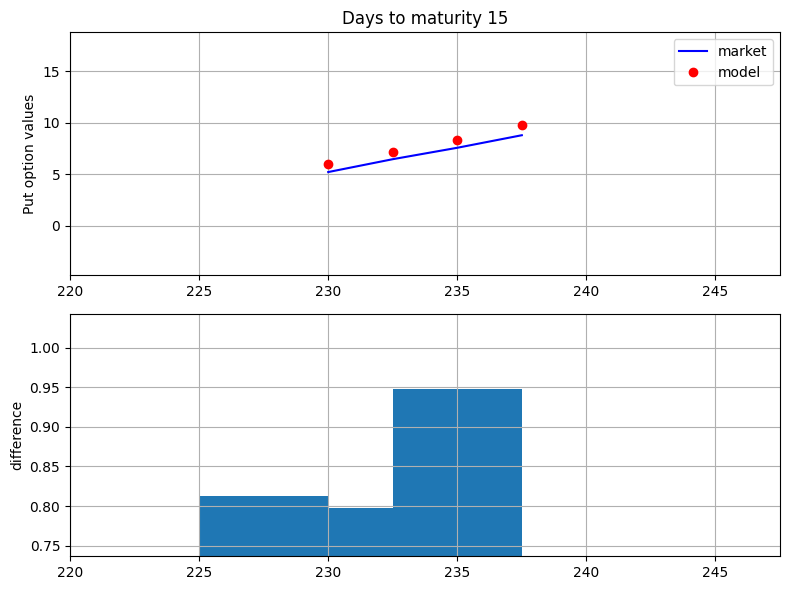

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
plt.ylabel("Put option values")
plt.plot(options.Strike, options.Put, "b", label="market")
plt.plot(options.Strike, options.H93_Put_CM, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(options.Put) - 10,
        max(options.Put) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options.H93_Put_CM.values - options.Put.values
plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options.Strike) - 10,
        max(options.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

The Heston model is an established model for option pricing as it is known for its ability to account for stochastic nature of volatility.This implies that volatility of the underlying asset is not constant, but follows a random process.

The Carr-Madan pricing approach is a computationally efficient method for option pricing under the Heston model. It uses the Fourier transform to invert the Heston characteristic function of the Heston model.

To calibrate the Heston model, we followed these steps:

1. market data for call and put options on the stock of the company SM with a 15-day maturity were collected.A grid of parameter values for the Heston model parameters was defined.
2. the Carr-Madan pricing approach was used to calculate the model prices for each set of parameters.
which were then compared to market prices by calculating the mean squared error (MSE).
3. used the brute-force global search and local minimization algorithms to find the set of parameters that minimizes the MSE.

the resulting callibrated parameters are:

- $\kappa$= 1.19767001
- $\theta$= 0.09007018
- $\sigma$= 0.46448758
- $\rho$= -0.99981037
- $\text{volatility}$= 0.10819943

Observation:

It's important to note that the calibrated parameters are very close to those obtained using the Lewis approach despite the different optimization algorithms used. The brute-force global search and local minimization algorithms are better suited to find the global minimum of the objective function, even if it is non-convex. on the other hand, the Lewis approach is more prone to find a local minimum.

The calibrated parameters are able to replicate the market prices of options with a 15-day maturity with a high degree of accuracy as seen in the graphs above



The market data provided includes:
* Five strike prices: 227.5, 230.0, 232.5, 235, and 237.5; and
* Three maturities: 15, 60 and 120 days;

**STEP 1. c)** <br>
Asian options are exotic and OTC instruments so need to be priced accordingly. An Asian call option payoff at maturity is given by
$$ max(Avg(S_t) − K; 0)\  for\ t = \{0, 1, ...T\}$$

and the maturity date required is 20 days. Ideally the model parameters are determined from market data including the desired strike and maturity with model calibration using the call and put prices simultaneously. Team member A has provided the calibration parameters.

Choices and assumptions:
* to convert days to year for consistent units of r and T we used 250 trading days, as provided (365 calendar days/year or 252 trading days/year is also an option)
* for calibration ideally, both call and put market prices should be used simultaneously for accuracy and appropriate error function used. However, we can still use only call or put to calibrate without much loss of accuracy.

for both calls and puts. Ideally it would have been great to have the market data for the current price ($S_0$=\$232.90) and desired maturity date (20 days) so I interpolated these.

*   The "fair price" of the instrument using Monte-Carlo methods in risk-neutral
setting for 20,000 simulations (enough iteration for reliable estimate) is coming out to be \$5.04.
* The Asian call price of \$5.26 includes a 4% service fee applied on top of the fair price for the pricing service and risk unaccounted by the model.

* A brief non-techinical description on the pricing that client can understand of pricing, including calibration steps is provided in report.

**Optimal simulations=20,000:** To determine the number of simulations needed for reliable and stable estimates, we can run the Monte Carlo simulations for different numbers of paths and plot the results to observe the convergence of the option prices.

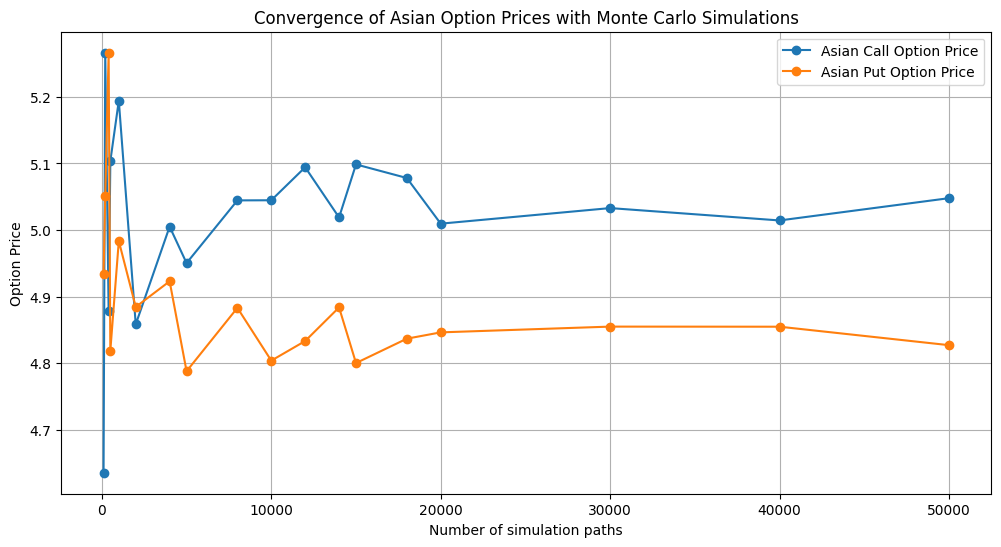

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Heston model parameters
kappa_v = 1.1977
theta_v = 0.0901
sigma_v = 0.4645
rho = -0.9998
v0 = 0.1082

# Option parameters
S0 = 232.90 # initial stock price
K = S0 # strike price
r = 0.015 # risk-free rate
T = 20 / 250.0 # time to maturity (20 days / 250.0 year)
M = 100 # number of time steps

# Monte Carlo simulation function
def monte_carlo_asian_option_price(S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I):
  dt = T / M # time increment

  # Preallocate arrays for stock price paths and volatility paths
  S = np.zeros((M + 1, I))
  v = np.zeros((M + 1, I))

  # Set initial values
  S[0] = S0
  v[0] = v0

  # Generate paths
  np.random.seed(42) # for reproducibility
  for t in range(1, M + 1):
    z1 = np.random.standard_normal(I) # standard normal random numbers
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(I)

    v[t] = np.maximum(v[t - 1] + kappa_v * (theta_v - v[t - 1]) * dt + sigma_v * np.sqrt(v[t - 1] * dt) * z1, 0)
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1] * dt) * z2)

  # Calculate the average stock price over the path
  S_avg = np.mean(S, axis=0)

  # Calculate the payoffs for Asian Call and Put options
  call_payoff = np.maximum(S_avg - K, 0)
  put_payoff = np.maximum(K - S_avg, 0)

  # Discount payoffs back to present value
  call_option_price = np.exp(-r * T) * np.mean(call_payoff)
  put_option_price = np.exp(-r * T) * np.mean(put_payoff)

  return call_option_price, put_option_price

# Define range of simulation paths
simulation_runs = [100,200,400, 500, 1000, 2000,4000, 5000, 8000,10000, 12000,14000,15000,18000, 20000, 30000, 40000, 50000]

call_prices = []
put_prices = []

# Perform simulations for different number of paths
for I in simulation_runs:
  call_price, put_price = monte_carlo_asian_option_price(S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I)
  call_prices.append(call_price)
  put_prices.append(put_price)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(simulation_runs, call_prices, label='Asian Call Option Price', marker='o')
plt.plot(simulation_runs, put_prices, label='Asian Put Option Price', marker='o')
plt.xlabel('Number of simulation paths')
plt.ylabel('Option Price')
plt.title('Convergence of Asian Option Prices with Monte Carlo Simulations')
plt.legend()
plt.grid(True)
plt.show()

This code prices an Asian option using the Monte Carlo method and the Heston (1993) model with the calibrated parameters. This code simulates paths for the stock price and volatility using the Heston model and computes the price of an Asian call option with a 20-day maturity. It uses the Monte Carlo method to estimate the expected payoff () and discounts it back to present value.



In [ ]:
import numpy as np

# Heston model parameters
kappa_v = 1.1977
theta_v = 0.0901
sigma_v = 0.4645
rho = -0.9998
v0 = 0.1082

# Option parameters
S0 = 232.90 # initial stock price
K = S0 # strike price
r = 0.015 # risk-free rate
T = 20 / 250.0 # time to maturity (20 days / 250.0 year)
M = 100 # number of time steps
I = 20000 # number of simulation paths

call_option_price, put_option_price = monte_carlo_asian_option_price(S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I)
print("S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I")
print(S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I)
print(f'The price of the Asian call option is: {call_option_price:.2f}')
print(f'The price of the Asian put option is: {put_option_price:.2f}')

S0,K,r,T,M,kappa_v,theta_v,sigma_v,rho,v0,I
232.9 232.9 0.015 0.08 100 1.1977 0.0901 0.4645 -0.9998 0.1082 20000
The price of the Asian call option is: 5.01
The price of the Asian put option is: 4.85


I=20,000 <br>
The price of the Asian call option is: 5.04 <br>
The price of the Asian put option is: 4.80<br>
I=10,000 <br>
The price of the Asian call option is: 5.01 <br>
The price of the Asian put option is: 4.85 <br>

Observation: note that the Asian options are cheaper than the corresponding vanila(European) options as the payoff is based on average price rather than sport price(higher volatility => greter risk and more premium).

**STEP 2**. a) calibrate Bates (1996) model using the Lewis (2001) approach with a regular MSE error function. for 60 day maturity.

Before calibrating, its better to interpolate the market data to obtain the option pricing for the Strike price and the 60 day maturity period which helps the calibration process. For ATM we could also use the market data with a 2% tolerance level to define ATM.


<br>
we will use Lewis (2001) approach to fully calibrate Bates (1996) model based on market data provided.
Bates (1996) requires a three step sequential procedure


1.   First we calibrate the stochastic volatility component of a Heston (1993) type of model.
2.   Then, we use those parameters to calibrate the jump component of Bates (1996).
3. Finally, we calibrate, via local optimization, the general model.

for starting guess we will use the parameters calibrated earlier for 15 day maturity

Following are the parameters from calibration of the Heston (1993) model:

- $\kappa_\nu = 1.1977$
- $\theta_\nu = 0.0901$
- $\sigma_\nu = 0.4645$
- $\rho = -0.9998$
- $\nu_0 = 0.1082$


In [ ]:
# 15 day maturity : calibrated parameters
kappa_v = 1.1977
theta_v = 0.0901
sigma_v = 0.4645
rho = -0.9998
v0 = 0.1082

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [ ]:
# Option Parameters
S0 = 232.90
days_in_year =  250.0 # 365.0, calendar days # 255.0 market trading days in year
# market data:
file_path = 'https://drive.google.com/uc?export=download&id=1bEtSz420806bYwNRG6njocjNSVQKFVp0'
data = pd.read_csv(file_path)
# reformatting table
modified_data = data.pivot_table(
    index=["Days to maturity", "Strike"],
    columns="Type",
    values="Price",
    aggfunc="first"
).reset_index()
modified_data.columns = ["Days to maturity", "Strike", "Call", "Put"]

In [ ]:
# define funtions for interpolation
# Function to interpolate strike
from scipy.interpolate import interp1d
def interpolate_strike(df, strike_value):
  interpolated_values = []
  for days in df['Days to maturity'].unique():
    subset = df[df['Days to maturity'] == days]
    f_c = interp1d(subset['Strike'], subset['Call'], kind='linear', fill_value="extrapolate")
    f_p = interp1d(subset['Strike'], subset['Put'], kind='linear', fill_value="extrapolate")

    interpolated_c = f_c(strike_value)
    interpolated_p = f_p(strike_value)
    interpolated_values.append({
    "Days to maturity": days,
    "Strike": strike_value,
    "Call": np.round(interpolated_c,2),
    "Put": np.round(interpolated_p,2)
    }
                               )

  return pd.DataFrame(interpolated_values)

# Function to interpolate Maturity
def interpolate_maturity(df, maturity_value):
  interpolated_values = []
  for strike in df['Strike'].unique():
    subset = df[df['Strike'] == strike]
    f_c = interp1d(subset['Days to maturity'], subset['Call'], kind='linear', fill_value="extrapolate")
    f_p = interp1d(subset['Days to maturity'], subset['Put'], kind='linear', fill_value="extrapolate")

    interpolated_c = f_c(maturity_value)
    interpolated_p = f_p(maturity_value)
    interpolated_values.append({
    "Days to maturity": maturity_value,
    "Strike": strike,
    "Call": np.round(interpolated_c,2),
    "Put": np.round(interpolated_p,2)
    }
                               )

  return pd.DataFrame(interpolated_values)

In [ ]:
# for comparison of options prices of 1C
# Interpolate values for Strike = 232.90
strike_value = 232.90

interpolated_df = interpolate_strike(modified_data, strike_value)
# Append interpolated_df to the original df
df = pd.concat([modified_data, interpolated_df], ignore_index=True)
df = df.sort_values(by=['Days to maturity', 'Strike']).reset_index(drop=True)
# Interpolate values for maturity = 20 days
maturity_value = 20
interpolated_df = interpolate_maturity(df, maturity_value)
df = pd.concat([df, interpolated_df], ignore_index=True)
df = df.sort_values(by=['Days to maturity', 'Strike']).reset_index(drop=True)

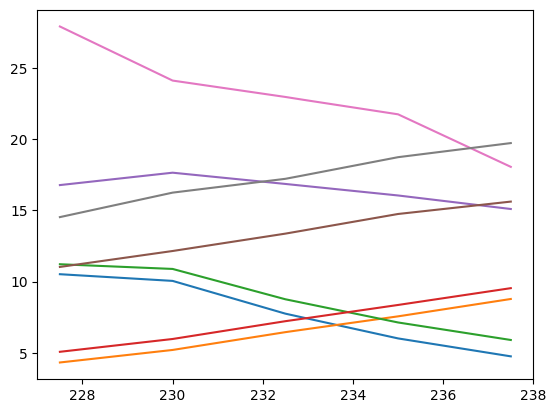

In [ ]:
# visualize the data
for days in df['Days to maturity'].unique():
  subset = df[df['Days to maturity'] == days]
  plt.plot(subset['Strike'], subset['Call'], label=f'Days to Maturity: {days}')
  plt.plot(subset['Strike'], subset['Put'], label=f'Days to Maturity: {days}')

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    put_value = call_value - S0 + K * np.exp(-r * T)
    return call_value

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

# Option Selection
tol = 0.02 # Tolerance level to select ATM options (percent around ITM/OTM options)
options_2 = modified_data[(modified_data['Days to maturity']==60) & ((np.abs(data["Strike"] - S0) / S0) < tol)]
options_2

for row, option in options_2.iterrows():
  T = option['Days to maturity'] / 250.0
  options_2.loc[row, "T"] = T
  options_2.loc[row, "r"] = 0.015

<ipython-input-46-a09286266b98>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  options_2 = modified_data[(modified_data['Days to maturity']==60) & ((np.abs(data["Strike"] - S0) / S0) < tol)]
<ipython-input-46-a09286266b98>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_2.loc[row, "T"] = T
<ipython-input-46-a09286266b98>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_2.loc[row, "r"] = 0.015


market date of ATM options to calibrate on

In [ ]:
options_2

,Days to maturity,Strike,Call,Put,T,r
6,60,230.0,17.65,12.15,0.24,0.015
7,60,232.5,16.86,13.37,0.24,0.015
8,60,235.0,16.05,14.75,0.24,0.015
9,60,237.5,15.10,15.62,0.24,0.015


In [ ]:
options_2

,Days to maturity,Strike,Call,Put,T,r
6,60,230.0,17.65,12.15,0.24,0.015
7,60,232.5,16.86,13.37,0.24,0.015
8,60,235.0,16.05,14.75,0.24,0.015
9,60,237.5,15.10,15.62,0.24,0.015


In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

Simultaneous call and put option calibration error function

In [ ]:
def B96_call_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    # $C_0 + Ke^{-rT} = S_0 + P_0$  call-put parity
    put_value = call_value + K*np.exp(-r*T) - S0
    print(f"Call Price (C): {call_value:.2f}")
    print(f"Put Price (P): {put_value:.2f}")

    return call_value,put_value

In [ ]:
def B96_error_call_put_function(p0_call_put):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0_call_put
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value[0] - option["Call"] ) ** 2)
        se.append((model_value[1] - option["Put"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0_call_put), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0_call_put - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
def B96_calibration_call_put_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_call_put_function,
        (
            (0.0, 5, 0.1),  # lambda
            (-0.5, 0.2, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_call_put_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=1000,
        maxfun=2000,
    )
    return opt2

In [ ]:
params_call_put = B96_calibration_call_put_short()

Streaming output truncated to the last 5000 lines.
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.02
Call Price (C): 17.18
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.01
Call Price (C): 17.19
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.02
Call Price (C): 17.19
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.02
1150 | [ 7.09576417e+00 -3.99031028e-02  3.64495355e-04] |   1.649 |   1.648
Call Price (C): 17.19
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.01
Call Price (C): 17.19
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P

In [ ]:
params_call_put
lamb_call_put = params_call_put[0]
mu_call_put = params_call_put[1]
delta_call_put = params_call_put[2]
# p0_call_put = [kappa_v_call_put, theta_v_call_put, sigma_v_call_put, rho_call_put, v0_call_put, lamb_call_put, mu_call_put, delta_call_put]
p0_call_put = [kappa_v, theta_v, sigma_v, rho, v0, lamb_call_put, mu_call_put, delta_call_put]

In [ ]:
params_call_put

array([ 2.86700055e+01, -1.99044314e-02,  1.35933645e-06])

params_call_put:

array([ 2.86700055e+01, -1.99044314e-02,  1.35933645e-06])

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_call_put_function(p0_call_put):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0_call_put

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value[0] - option["Call"]) ** 2)
        se.append((model_value[1] - option["Put"]) ** 2)


    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0_call_put), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_call_put_full():
    opt = fmin(
        B96_full_error_call_put_function, p0_call_put, xtol=0.001, ftol=0.001, maxiter=10000, maxfun=10000
    )
    return opt

In [ ]:
B96_full_error_call_put_function(p0_call_put)

Call Price (C): 17.18
Put Price (P): 13.46
Call Price (C): 15.82
Put Price (P): 14.58
Call Price (C): 14.51
Put Price (P): 15.77
Call Price (C): 13.27
Put Price (P): 17.02
   0 | [ 1.19770000e+00  9.01000000e-02  4.64500000e-01 -9.99800000e-01
  1.08200000e-01  2.86700055e+01 -1.99044314e-02  1.35933645e-06] |   1.648 |   1.648


1.6475484549723665

In [ ]:
def B96_calculate_call_put_model_values(p0_call_put):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0_call_put
    call_values = []
    put_values = []
    for row, option in options_2.iterrows():
        call_value = B96_call_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        put_value = call_value - S0 + option["Strike"] * np.exp(-option["r"] * option["T"])


        call_values.append(call_value)
        put_values.append(put_value)

    return np.array(call_values), np.array(put_values)

In [ ]:
full_params_call_put = B96_calibration_call_put_full()

Streaming output truncated to the last 5000 lines.
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Call Price (C): 16.94
Put Price (P): 13.22
Call Price (C): 15.73
Put Price (P): 14.50
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Call Price (C): 16.94
Put Price (P): 13.22
Call Price (C): 15.73
Put Price (P): 14.50
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Call Price (C): 16.94
Put Price (P): 13.22
Call Price (C): 15.73
Put Price (P): 14.49
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Call Price (C): 16.94
Put Price (P): 13.22
Call Price (C): 15.73
Put Price (P): 14.49
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Call Price (C): 16.94
Put Price (P): 13.22
Call Price (C): 15.73
Put Price (P): 14.49
Call Price (C): 14.58
Put Price (P): 15.84
Call Price (C): 13.50
Put Price (P): 17.25
Cal

In [ ]:
full_params_call_put

array([ 2.40535694e+00,  3.13283649e-01,  1.35376957e-01,  5.73392933e-01,
        4.27051425e-02,  9.48390911e+01, -5.81403878e-03,  2.20674081e-15])

In [ ]:
p_call_put_2a = full_params_call_put

full_params_call_put :  <br> array([ 2.72894893e+00,  3.26215001e-01,  6.59797633e-01,  9.99957194e-01,
        5.96598318e-02,  3.38981899e+01, -1.65000802e-08,  1.05630410e-09])

In [ ]:
kappa_v_call_put_2a = full_params_call_put[0]
theta_v_call_put_2a = full_params_call_put[1]
sigma_v_call_put_2a = full_params_call_put[2]
rho_call_put_2a = full_params_call_put[3]
v0_call_put_2a = full_params_call_put[4]
lamb_call_put_2a = full_params_call_put[5]
mu_call_put_2a = full_params_call_put[6]
delta_call_put_2a = full_params_call_put[7]

In [ ]:
options_2["B96_Call"], options_2["B96_Put"] = B96_calculate_model_values(p_call_put_2a)
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options_2["Days to maturity"].iloc[0])[:10])
plt.ylabel("Call option values")
plt.plot(options_2.Strike, options_2.Call, "b", label="market")
plt.plot(options_2.Strike, options_2.B96_Call, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(options_2.Call) - 10,
        max(options_2.Call) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options_2.B96_Call.values - options_2.Call.values
plt.bar(options_2.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

NameError: name 'B96_calculate_model_values' is not defined

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options_2["Days to maturity"].iloc[0])[:10])
plt.ylabel("Put option values")
plt.plot(options_2.Strike, options_2.Put, "b", label="market")
plt.plot(options_2.Strike, options_2.B96_Put, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(options_2.Put) - 10,
        max(options_2.Put) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options_2.B96_Put.values - options_2.Put.values
plt.bar(options_2.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 5, 0.1),  # lambda
            (-0.5, 0.2, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=1000,
        maxfun=2000,
    )
    return opt2

In [ ]:
params = B96_calibration_short()

In [ ]:
params
lamb = params[0]
mu = params[1]
delta = params[2]
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
params

params:
array([ 2.49328974e+02, -8.55054780e-15,  1.10888445e-02])
params_call_put:
array([ 2.86700055e+01, -1.99044314e-02,  1.35933645e-06])



In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=10000, maxfun=10000
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    call_values = []
    put_values = []
    for row, option in options_2.iterrows():
        call_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        put_value = call_value - S0 + option["Strike"] * np.exp(-option["r"] * option["T"])


        call_values.append(call_value)
        put_values.append(put_value)

    return np.array(call_values), np.array(put_values)

In [ ]:
full_params = B96_calibration_full()

In [ ]:
full_params

In [ ]:
kappa_v_2a = full_params[0]
theta_v_2a = full_params[1]
sigma_v_2a = full_params[2]
rho_2a = full_params[3]
v0_2a = full_params[4]
lamb_2a = full_params[5]
mu_2a = full_params[6]
delta_2a = full_params[7]

**STEP 2**. b) Carr-Madan (1999) approach to Bates (1996) model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

# Option Selection
tol = 0.02 # Tolerance level to select ATM options (percent around ITM/OTM options)
options_2 = modified_data[(modified_data['Days to maturity']==60) & ((np.abs(data["Strike"] - S0) / S0) < tol)]
options_2

for row, option in options_2.iterrows():
  T = option['Days to maturity'] / 250.0
  options_2.loc[row, "T"] = T
  options_2.loc[row, "r"] = 0.015

In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 5, 0.1),  # lambda
            (-0.5, 0.2, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=1000,
        maxfun=2000,
    )
    return opt2

In [ ]:
params = B96_calibration_short()

In [ ]:
params
lamb = params[0]
mu = params[1]
delta = params[2]
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_2.iterrows():
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=10000, maxfun=10000
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    call_values = []
    put_values = []
    for row, option in options_2.iterrows():
        call_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        put_value = call_value - S0 + option["Strike"] * np.exp(-option["r"] * option["T"])


        call_values.append(call_value)
        put_values.append(put_value)

    return np.array(call_values), np.array(put_values)

In [ ]:
full_params = B96_calibration_full()

In [ ]:
full_params


In [ ]:
kappa_v = full_params[0]
theta_v = full_params[1]
sigma_v = full_params[2]
rho = full_params[3]
v0 = full_params[4]
lamb = full_params[5]
mu = full_params[6]
delta = full_params[7]



In [ ]:
p0 = full_params

In [ ]:
options_2["B96_Call"], options_2["B96_Put"] = B96_calculate_model_values(p0)
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options_2["Days to maturity"].iloc[0])[:10])
plt.ylabel("Call option values")
plt.plot(options_2.Strike, options_2.Call, "b", label="market")
plt.plot(options_2.Strike, options_2.B96_Call, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(options_2.Call) - 10,
        max(options_2.Call) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options_2.B96_Call.values - options_2.Call.values
plt.bar(options_2.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

In [ ]:
options_2.B96_Put

In [ ]:
options_2.B96_Call

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.grid()
plt.title("Days to maturity %s" % str(options_2["Days to maturity"].iloc[0])[:10])
plt.ylabel("Put option values")
plt.plot(options_2.Strike, options_2.Put, "b", label="market")
plt.plot(options_2.Strike, options_2.B96_Put, "ro", label="model")
plt.legend(loc=0)
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(options_2.Put) - 10,
        max(options_2.Put) + 10,
    ]
)
plt.subplot(212)
plt.grid()
wi = 5.0
diffs = options_2.B96_Put.values - options_2.Put.values
plt.bar(options_2.Strike.values - wi / 2, diffs, width=wi)
plt.ylabel("difference")
plt.axis(
    [
        min(options_2.Strike) - 10,
        max(options_2.Strike) + 10,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)
plt.tight_layout()

**STEP 2c.**
Team member B will perform a pricing process similar to Task (c) of Step 1. In
this case, rather than an OTC instrument, the client has decided she wants to buy
a Put option on firm SM with 70 days maturity and moneyness of 95% (i.e., stri
is 95% of the current price).

To do this step, we first calculated the price of an Asian Put option whose value is determined using these given parameters: current price (S0) at $232.90, strike price (K) = 95% of the current price, maturity is 70/250 days, and annual risk free rate = 1.5%. Since the Asian put option uses a Monte Carlo simulation approach. so, random price paths for the underlying asset are generated while considering factors like the asset's drift, volatility, and time step size. For each simulated path, the Asian Put option's payoff is computed as the maximum between the strike price and the average asset price, with negative differences truncated at zero. The Asian Put option price is ultimately computed as the discounted average of these payoffs across all simulation paths. Simulation parameters, such as the number of time steps (N), simulation paths (M), and a seed value for random number generation, are also defined.



Our Asian Put option price  $5.21. This shows that under the specified assumptions and simulation conditions, the fair value of this option is 5.21. It is the estimated cost or value of buying the option, providing better understanding of the option's market valuation given the model's assumptions and stochastic simulations.


In [ ]:
# parameters
S0 = 232.90  #price of firm SM
K = 0.95 * S0  # Strike price (95%)
T = 70 / 250  # 70 days maturity
r = 0.015  # Annual rate
sigma_v = 0.36897781  # Volatility (using calibrated sigma v)

# Define the Asian Put option pricing function
def asian_put_option_price(S0, K, T, r, sigma_v, N, M, seed_value):
    dt = T / N
    np.random.seed(seed_value)

    asian_put_values = np.zeros(M)

    for i in range(M):
        S = np.zeros(N + 1)
        S[0] = S0

        for t in range(N):
            S[t + 1] = S[t] * np.exp((r - 0.5 * sigma_v**2) * dt + sigma_v * np.sqrt(dt) * np.random.normal(0, 1))

        asian_put_values[i] = np.maximum(K - np.mean(S), 0)

    asian_put_price = np.exp(-r * T) * np.mean(asian_put_values)

    return asian_put_price


N = 250  # No of time steps
M = 100000  # No of simulation paths
seed_value = 34  # Seed

# Calculate the Asian Put option price
asian_put_price = asian_put_option_price(S0, K, T, r, sigma_v, N, M, seed_value)

# Print the Asian Put option price
print(f"Asian Put Option Price: {asian_put_price:.2f}")


(ii) As part of the bank’s profit, you charge a 4% fee on the price to obtain the final price that the client will end up paying. Make sure to clearly state this in your report.

Since the bank charges a 4% fee on the price of the Asian Put option, the price that the client will pay for the option will be higher than our calculated option price of $5.21. This fee is added to the option price to determine the total cost for the client. The calculation is now:

**(a) Calculate Fee Amount:**
With a fee of 4% the option price, which is 4% of $5.21. Hence,  Fee Amount = 4 percent Option Price.
Fee Amount = 0.04 * 5.21 = $0.2084.

**(b) To calculate the Final Price for the Client:**
The final price the client will pay is the sum of the initial option price and fee amount.
Final Price = Option Price + Fee Amount.
Final Price = $5.21 + $0.2084 = $5.4184.

Therefore, if the bank charges a 4% fee on the Asian Put option with an initial price of $5.21, the client will end up paying a total price of approximately $5.42 for the option. This accounts for both the option's market price and the bank's fee.


In [ ]:
#  parameters
S0 = 232.90  #price of firm SM
K = 0.95 * S0  # Strike price (95%)
T = 70 / 250  # 70 days maturity
r = 0.015  # Annual rate
sigma_v = 0.36897781  # Volatility (using calibrated sigma v

# number of simulations and time steps
num_simulations = 100000  # No of simulations
num_time_steps = int(T * 250)  # No of time steps (using daily)

# store simulation results
option_payoffs = np.zeros(num_simulations)

# Monte Carlo simulations
for i in range(num_simulations):
    price_path = [S0]
    for t in range(1, num_time_steps + 1):
        # Generate daily returns following a Brownian motion
        daily_return = np.random.normal((r - 0.5 * sigma_v**2) * (1 / 250), sigma_v / np.sqrt(250))
        price_today = price_path[-1] * np.exp(daily_return)
        price_path.append(price_today)

    # Calculate the Asian Put option payoff
    asian_average_price = np.mean(price_path)
    option_payoff = max(K - asian_average_price, 0)

    option_payoffs[i] = option_payoff

# Calculate the estimated option price as the mean of payoffs, discounted to present value
option_price = np.exp(-r * T) * np.mean(option_payoffs)

# Calculate the fee (4% of the option price)
fee = 0.04 * option_price

# Calculate the final price the client will pay (option price plus fee)
final_price = option_price + fee

# Print the estimated option price and final price
print("Estimated Asian Put Option Price using Monte Carlo: {:.2f}".format(option_price))
print("Client's Final Price (including 4% fee): {:.2f}".format(final_price))


**Step 3. a.** Calibrate a CIR (1985) model considering current rates, describing the overall
process.

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

In [ ]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
from scipy.interpolate import splev, splrep

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 48
)  # Create 48 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
from scipy.optimize import fmin

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_calibrated_frc(params)

In [ ]:
k = 0.99797274
theta = 0.10751944
sigma = 0.00100614


**CIR model Euribor simulation**

Now having obtained the parameters from our calibration on the last step we can simulate our calibrated model via Monte Carlo, we start by defining our model

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [ ]:
k,theta,sigma=params
T=1
N=360
M=100_000
t = np.linspace(0, T, N)
r0=rate_list[0]

In [ ]:
rates_cir = cir(r0, k, theta, sigma, T, N, M)

In [ ]:
for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
def get_confidence_levels(data):
    return stats.norm.interval(0.9, loc=np.mean(data), scale=np.std(data)/np.sqrt(len(data)))
def get_confidence_levels2(data):
    return stats.norm.interval(0.9, loc=np.mean(data), scale=np.std(data))

In [ ]:
l,h=list(zip(*[get_confidence_levels(i) for i in rates_cir]))
l2,h2=list(zip(*[get_confidence_levels2(i) for i in rates_cir]))

In [ ]:
for j in range(M):
  plt.plot(t, rates_cir[:, j],alpha=0.05)
plt.plot(t,h,c='k')
plt.plot(t,l,c='k')
plt.plot(t,h2,c='g')
plt.plot(t,l2,c='g')
plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

The Green line is confidence interval for 1 draw of the distribution and black one is for the mean of N draws of the distribution

In [ ]:
print(f'The expectation value is {(max(h)+max(l))/2} +/- {(max(h)-max(l))} for the case of the mean of N draws')

In [ ]:
print(f'The expectation value is {(max(h2)+max(l2))/2} +/- {(max(h2)-max(l2))} for the case of the mean of a single draw')

**How will this expected number affect the pricing of your products in 1 year versus the current 12-month Euribor rate?**

As the free rate Euribor is expected to increase, we expect stocks to be a less sought for investment as the premium obtained by risk is increasing. so, we would be wise to price put options with long maturities higher as those are more likely to happen as the euribor free rate increases, and also more sought after in a high interest rate environment.